# Selling Strangles before CPI — JSON viewer and charts

This notebook loads the JSON file `Selling Strangles  before CPI.json` from the workspace, shows the top-level keys, a preview of orders (if present), key statistics, and charts (profit/loss series and order price distribution). Use the code cells below to run and render the data and plots.

In [3]:
import json
import pandas as pd
from IPython.display import display, Markdown

# Path to the JSON file in your Downloads workspace
json_path = r"c:\Users\Naeem\Downloads\Selling Strangles  before CPI.json"

# Load the JSON
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Show top-level keys
display(Markdown('#### Top-level keys'))
display(list(data.keys()))

# Orders: convert dict-of-dicts to DataFrame (if present)
orders_df = None
if 'orders' in data and isinstance(data['orders'], dict):
    try:
        orders_df = pd.DataFrame.from_dict(data['orders'], orient='index')
        display(Markdown('#### Orders (first 10 rows)'))
        display(orders_df.head(10))
    except Exception as e:
        display(Markdown(f"**Failed to parse orders:** {e}"))

# Profit/Loss series (if present)
pl = None
if 'profitLoss' in data and isinstance(data['profitLoss'], dict):
    try:
        pl = pd.Series(data['profitLoss']).sort_index()
        pl.index = pd.to_datetime(pl.index)
        display(Markdown('#### Profit/Loss (first 10 entries)'))
        display(pl.head(10))
    except Exception as e:
        display(Markdown(f"**Failed to parse profitLoss:** {e}"))

# Statistics (if present)
stats_df = None
if 'statistics' in data and isinstance(data['statistics'], dict):
    stats_df = pd.DataFrame(list(data['statistics'].items()), columns=['metric','value'])
    display(Markdown('#### Statistics'))
    display(stats_df)

print('Variables available: data, orders_df, pl, stats_df')

#### Top-level keys

['rollingWindow',
 'totalPerformance',
 'charts',
 'orders',
 'profitLoss',
 'statistics',
 'runtimeStatistics',
 'state',
 'algorithmConfiguration']

#### Orders (first 10 rows)

,type,quantity,id,contingentId,brokerId,symbol,price,priceCurrency,time,createdTime,...,status,tag,properties,securityType,direction,value,orderSubmissionData,isMarketable,groupOrderManager,priceAdjustmentMode
1,8,-3.0,1,0,[1],"{'value': 'SPY 230112C00400000', 'id': 'SPY ...",1.87,USD,2023-01-11T20:55:00Z,2023-01-11T20:55:00Z,...,3,,{'timeInForce': {}},2,1,-5.61,"{'bidPrice': 1.87, 'askPrice': 1.88, 'lastPric...",True,"{'id': 1, 'quantity': -3.0, 'count': 2, 'limit...",0
2,8,-3.0,2,0,[2],"{'value': 'SPY 230112P00390000', 'id': 'SPY ...",1.91,USD,2023-01-11T20:55:00Z,2023-01-11T20:55:00Z,...,3,,{'timeInForce': {}},2,1,-5.73,"{'bidPrice': 1.91, 'askPrice': 1.92, 'lastPric...",True,"{'id': 1, 'quantity': -3.0, 'count': 2, 'limit...",0
3,0,3.0,3,0,[3],"{'value': 'SPY 230112C00400000', 'id': 'SPY ...",0.81,USD,2023-01-12T14:31:00Z,2023-01-12T14:31:00Z,...,3,,{'timeInForce': {}},2,0,2.43,"{'bidPrice': 0.8, 'askPrice': 0.81, 'lastPrice...",True,NaN,0
4,0,3.0,4,0,[4],"{'value': 'SPY 230112P00390000', 'id': 'SPY ...",0.28,USD,2023-01-12T14:31:00Z,2023-01-12T14:31:00Z,...,3,,{'timeInForce': {}},2,0,0.84,"{'bidPrice': 0.27, 'askPrice': 0.28, 'lastPric...",True,NaN,0
5,8,-3.0,5,0,[5],"{'value': 'SPY 230215C00415000', 'id': 'SPY ...",0.83,USD,2023-02-14T19:20:00Z,2023-02-14T19:20:00Z,...,3,,{'timeInForce': {}},2,1,-2.49,"{'bidPrice': 0.83, 'askPrice': 0.84, 'lastPric...",True,"{'id': 2, 'quantity': -3.0, 'count': 2, 'limit...",0
6,8,-3.0,6,0,[6],"{'value': 'SPY 230215P00410000', 'id': 'SPY ...",0.87,USD,2023-02-14T19:20:00Z,2023-02-14T19:20:00Z,...,3,,{'timeInForce': {}},2,1,-2.61,"{'bidPrice': 0.87, 'askPrice': 0.88, 'lastPric...",True,"{'id': 2, 'quantity': -3.0, 'count': 2, 'limit...",0
7,0,3.0,7,0,[7],"{'value': 'SPY 230215C00415000', 'id': 'SPY ...",1.10,USD,2023-02-14T19:41:00Z,2023-02-14T19:41:00Z,...,3,,{'timeInForce': {}},2,0,3.30,"{'bidPrice': 1.09, 'askPrice': 1.1, 'lastPrice...",True,NaN,0
8,0,3.0,8,0,[8],"{'value': 'SPY 230215P00410000', 'id': 'SPY ...",0.67,USD,2023-02-14T19:41:00Z,2023-02-14T19:41:00Z,...,3,,{'timeInForce': {}},2,0,2.01,"{'bidPrice': 0.66, 'askPrice': 0.67, 'lastPric...",True,NaN,0
9,8,-3.0,9,0,[9],"{'value': 'SPY 230315C00395000', 'id': 'SPY ...",1.14,USD,2023-03-14T16:20:00Z,2023-03-14T16:20:00Z,...,3,,{'timeInForce': {}},2,1,-3.42,"{'bidPrice': 1.14, 'askPrice': 1.15, 'lastPric...",True,"{'id': 3, 'quantity': -3.0, 'count': 2, 'limit...",0
10,8,-3.0,10,0,[10],"{'value': 'SPY 230315P00389000', 'id': 'SPY ...",1.11,USD,2023-03-14T16:20:00Z,2023-03-14T16:20:00Z,...,3,,{'timeInForce': {}},2,1,-3.33,"{'bidPrice': 1.11, 'askPrice': 1.12, 'lastPric...",True,"{'id': 3, 'quantity': -3.0, 'count': 2, 'limit...",0


**Failed to parse profitLoss:** time data "2023-01-12T14:31:00Z" doesn't match format "%Y-%m-%dT%H:%M:%S.%f%z", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

#### Statistics

,metric,value
0,Total Orders,140
1,Average Win,0.16%
2,Average Loss,-0.24%
3,Compounding Annual Return,0.694%
4,Drawdown,1.200%
5,Expectancy,0.117
6,Start Equity,100000
7,End Equity,101983.15
8,Net Profit,1.983%
9,Sharpe Ratio,-5.545


Variables available: data, orders_df, pl, stats_df


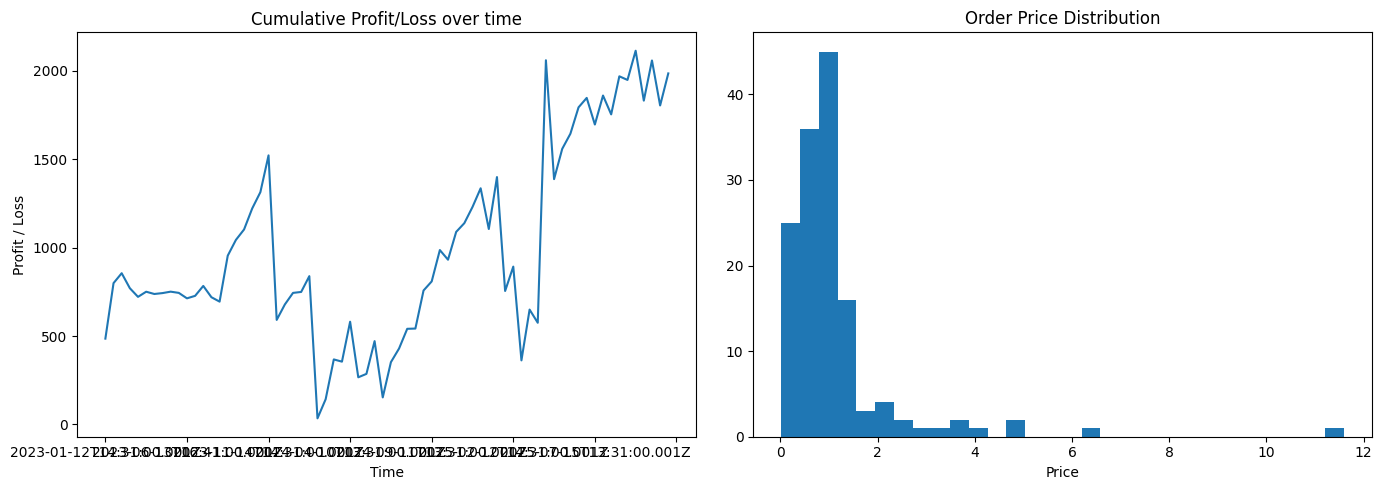

In [2]:
# Plotting: profit/loss and order price distribution (matplotlib with fallback)
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1,2, figsize=(14,5))

# Left: cumulative profit/loss over time
if 'pl' in globals() and pl is not None:
    try:
        (pl.cumsum()).plot(ax=axes[0], title='Cumulative Profit/Loss over time')
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Profit / Loss')
    except Exception as e:
        axes[0].text(0.5,0.5,f'Error plotting P/L: {e}', ha='center')
else:
    axes[0].text(0.5,0.5,'No profitLoss series found', ha='center')

# Right: order price histogram
if 'orders_df' in globals() and orders_df is not None and 'price' in orders_df.columns:
    try:
        prices = pd.to_numeric(orders_df['price'], errors='coerce').dropna()
        axes[1].hist(prices, bins=30)
        axes[1].set_title('Order Price Distribution')
        axes[1].set_xlabel('Price')
    except Exception as e:
        axes[1].text(0.5,0.5,f'Error plotting prices: {e}', ha='center')
else:
    axes[1].text(0.5,0.5,'No order prices found', ha='center')

plt.tight_layout()
plt.show()

Notes and next steps:

- If you want interactive charts, I can add Plotly versions (may need to pip-install `plotly`).
- Tell me which fields you want plotted (e.g., realized P/L, order price vs time, order quantity over time).
- I can also export an orders CSV if you'd like to analyze in Excel.

In [5]:
# Install/import Plotly (safe) and imports
import sys
import subprocess

try:
    import plotly.express as px
    import plotly.graph_objects as go
    import plotly as _plotly
except Exception:
    print('Plotly not found — installing plotly...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'plotly'])
    import plotly.express as px
    import plotly.graph_objects as go
    import plotly as _plotly

import numpy as np
import pandas as pd
from IPython.display import display, Markdown

print('plotly version:', _plotly.__version__)


plotly version: 5.24.1


In [7]:
# Interactive Plotly charts: cumulative P/L and rolling Sharpe; order price scatter
# Assumptions:
# - `pl` is a pd.Series of profit/loss amounts (same as loaded earlier)
# - Start equity is taken from data['statistics']['Start Equity'] if present, else 100000
# - Rolling window and annualization are configurable below

window = 30  # rolling window (number of observations)
annualization = 252  # used to annualize Sharpe (sqrt of periods per year)

# Prepare series
start_equity = 100000.0
try:
    se = data.get('statistics', {}).get('Start Equity', start_equity)
    start_equity = float(str(se).replace('$','').replace(',',''))
except Exception:
    start_equity = start_equity

if 'pl' in globals() and pl is not None:
    returns = pl.astype(float) / start_equity
    cum_pl = pl.cumsum()
    rolling_mean = returns.rolling(window).mean()
    rolling_std = returns.rolling(window).std()
    rolling_sharpe = rolling_mean / rolling_std * np.sqrt(annualization)

    # Build DataFrame for plotting
    df_plot = pd.DataFrame({
        'cum_pl': cum_pl,
        'returns': returns,
        'rolling_sharpe': rolling_sharpe
    })

    # Interactive figure with two y-axes
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot['cum_pl'], mode='lines', name='Cumulative P/L', yaxis='y1'))
    fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot['rolling_sharpe'], mode='lines', name=f'Rolling Sharpe (window={window})', yaxis='y2'))

    # Layout with secondary y-axis
    fig.update_layout(
        title=f'Cumulative P/L and Rolling Sharpe (window={window})',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Cumulative P/L', side='left'),
        yaxis2=dict(title='Rolling Sharpe', overlaying='y', side='right', showgrid=False),
        legend=dict(x=0.01, y=0.99)
    )

    # Show figure
    fig.show()
else:
    display(Markdown('**No profitLoss (pl) series available to compute rolling Sharpe.**'))

# Order price scatter
if 'orders_df' in globals() and orders_df is not None:
    if 'time' in orders_df.columns and 'price' in orders_df.columns:
        try:
            odf = orders_df.copy()
            odf['time_parsed'] = pd.to_datetime(odf['time'], errors='coerce')
            odf['price_numeric'] = pd.to_numeric(odf['price'], errors='coerce')
            odf = odf.dropna(subset=['time_parsed','price_numeric'])
            if not odf.empty:
                fig2 = px.scatter(odf, x='time_parsed', y='price_numeric', color='quantity', title='Order price vs time', labels={'price_numeric':'Price','time_parsed':'Time'})
                fig2.update_traces(marker=dict(size=6))
                fig2.show()
            else:
                display(Markdown('**Orders DataFrame exists but no valid time/price rows found for scatter.**'))
        except Exception as e:
            display(Markdown(f'**Failed plotting orders scatter:** {e}'))
    else:
        display(Markdown('**orders_df is present but lacks `time` or `price` columns.**'))
else:
    display(Markdown('**No orders_df present to plot order prices.**'))
